# Autoencoder for dim064 dataset

In [1]:
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
#read data
x_train = pd.read_csv('dataset/dim064_train.csv')
x_test = pd.read_csv('dataset/dim064_test.csv')
#y_train = pd.read_csv('dataset/dim064_train_label.csv')
#y_train = np.asarray(y_train)
#y_test = pd.read_csv('dataset/dim064_test_label.csv')
#y_test = np.asarray(y_test)

In [3]:
# ## Normalization
# #x_train.max().max()
# x_train = x_train.astype('float32') / 157.
# x_test = x_test.astype('float32') / 157.

# Basic Autoencoder

In [4]:
########### Basic Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [5]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose = 0
                ).history

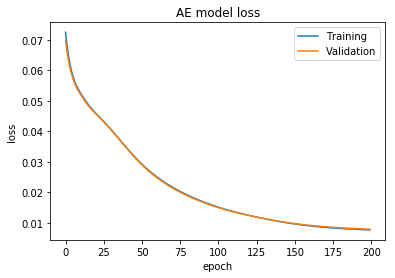

In [6]:
# AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [7]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

# get rid of columns with all zeros
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.shape

(410, 11)

In [8]:
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_AE_encoded.csv',index= False)

# Sparse Autoencoder

In [9]:
########### Sparse Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [11]:


ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose = 0
                ).history

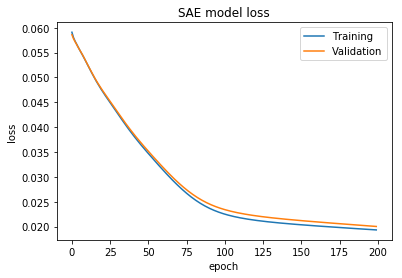

In [12]:
# SAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('SAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [13]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

# get rid of columns with all zeros
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_SAE_encoded.csv',index= False)

# Contractive Autoencoder

In [14]:
########### Contractive Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', name = 'encoded')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

lam = 10e-6

def contractive_loss(y_pred, y_true):
    
        mse = K.mean(K.square(y_true - y_pred), axis=1)
        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])
        W = K.transpose(W)
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    
autoencoder.compile(optimizer='adam', loss= contractive_loss)

In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64)                0         
_________________________________________________________________
encoded (Dense)              (None, 12)                780       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [16]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 0
                ).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


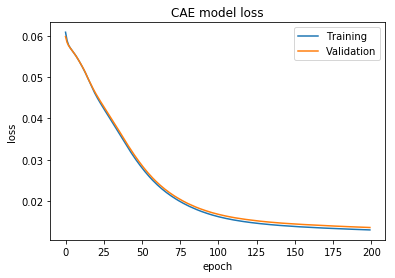

In [17]:
# CAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [18]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [19]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_CAE_encoded.csv',index= False)

# Denoising Autoencoder

In [20]:
############ Denoiding Autoencoder ###########

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 12
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                780       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                832       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [22]:
ae_train = autoencoder.fit(x_train_noisy, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test_noisy, x_test),
                verbose = 0
                ).history

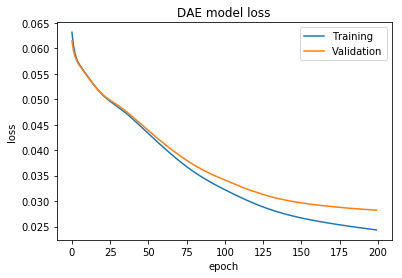

In [23]:
# DAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('DAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [24]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_DAE_encoded.csv',index= False)

# Convolutional Autoencoder

In [25]:
# input_dim = x_train.shape[1]

# # tranform the input format, add a dimension
# x_train_con = x_train.as_matrix()
# x_train_con = np.reshape(x_train_con, (-1, input_dim, 1))
# x_text_con = x_test.as_matrix()
# x_text_con = np.reshape(x_text_con, (-1, input_dim, 1))

# input_layer = Input(shape=(input_dim,1))

# x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
# x = MaxPooling1D(4, padding='same')(x)
# x = Conv1D(16, 3, activation='relu', padding='same')(x)
# x = MaxPooling1D(4, padding='same')(x)
# x = Conv1D(4, 3, activation='relu', padding='same')(x)
# encoded = MaxPooling1D(2, padding='same')(x)


# x = Conv1D(4, 3, activation='relu', padding='same')(encoded)
# x = UpSampling1D(2)(x)
# x = Conv1D(16, 3, activation='relu', padding='same')(x)
# x = UpSampling1D(4)(x)
# x = Conv1D(32, 3, activation='relu', padding='same')(x)
# x = UpSampling1D(4)(x)
# decoded = Conv1D(1, 1, activation='sigmoid')(x)

# autoencoder = Model(input_layer, decoded)
# encoder = Model(input_layer, encoded)
# autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
# autoencoder.summary()

In [27]:
# ae_train = autoencoder.fit(x_train_con, x_train_con,
#                 epochs=200,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_text_con, x_text_con),
#                 verbose = 0,
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]).history

In [28]:
# # Conv_AE loss
# plt.plot(ae_train['loss'])
# plt.plot(ae_train['val_loss'])
# plt.title('Conv_AE model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper right')
# plt.show()

In [29]:
############# add one conv1D layer, change encoding dimension to 12 (4*3) ~Boren ###############

input_dim = x_train.shape[1]

# tranform the input format, add a dimension
x_train_con = x_train.as_matrix()
x_train_con = np.reshape(x_train_con, (-1, input_dim, 1))
x_text_con = x_test.as_matrix()
x_text_con = np.reshape(x_text_con, (-1, input_dim, 1))

input_layer = Input(shape=(input_dim,1))

x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(3, 3, activation='relu', padding='same')(x) 
encoded = MaxPooling1D(2, padding='same')(x)


x = Conv1D(3, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 1, activation='sigmoid')(x)


autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [30]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 8)             392       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 8)              0         
__________

In [31]:
ae_train = autoencoder.fit(x_train_con, x_train_con,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_text_con, x_text_con),
                verbose=0
                ).history

Train on 614 samples, validate on 410 samples


Epoch 1/200
614/614 [==============================] - 3s 5ms/step - loss: 0.0578 - val_loss: 0.0574

Epoch 2/200
614/614 [==============================] - 0s 328us/step - loss: 0.0567 - val_loss: 0.0564
Epoch 3/200
614/614 [==============================] - 0s 323us/step - loss: 0.0557 - val_loss: 0.0557
Epoch 4/200
614/614 [==============================] - 0s 284us/step - loss: 0.0552 - val_loss: 0.0557
Epoch 5/200
614/614 [==============================] - 0s 301us/step - loss: 0.0552 - val_loss: 0.0556
Epoch 6/200
614/614 [==============================] - 0s 296us/step - loss: 0.0550 - val_loss: 0.0553
Epoch 7/200
614/614 [==============================] - 0s 307us/step - loss: 0.0548 - val_loss: 0.0552
Epoch 8/200
614/614 [==============================] - 0s 311us/step - loss: 0.0547 - val_loss: 0.0550
Epoch 9/200
614/614 [==============================] - 0s 301us/step - loss: 0.0544 - val_loss: 0.0548
Epoch 10/200
614/614 [====

614/614 [==============================] - 0s 306us/step - loss: 0.0406 - val_loss: 0.0413
Epoch 74/200
614/614 [==============================] - 0s 297us/step - loss: 0.0404 - val_loss: 0.0411
Epoch 75/200
614/614 [==============================] - 0s 296us/step - loss: 0.0402 - val_loss: 0.0410
Epoch 76/200
614/614 [==============================] - 0s 297us/step - loss: 0.0401 - val_loss: 0.0408
Epoch 77/200
614/614 [==============================] - 0s 301us/step - loss: 0.0399 - val_loss: 0.0407
Epoch 78/200
614/614 [==============================] - 0s 318us/step - loss: 0.0398 - val_loss: 0.0406
Epoch 79/200
614/614 [==============================] - 0s 307us/step - loss: 0.0396 - val_loss: 0.0404
Epoch 80/200
614/614 [==============================] - 0s 298us/step - loss: 0.0395 - val_loss: 0.0403
Epoch 81/200
614/614 [==============================] - 0s 284us/step - loss: 0.0393 - val_loss: 0.0401
Epoch 82/200
614/614 [==============================] - 0s 297us/step - loss:

614/614 [==============================] - 0s 309us/step - loss: 0.0346 - val_loss: 0.0354
Epoch 152/200
614/614 [==============================] - 0s 303us/step - loss: 0.0345 - val_loss: 0.0354
Epoch 153/200
614/614 [==============================] - 0s 317us/step - loss: 0.0345 - val_loss: 0.0353
Epoch 154/200
614/614 [==============================] - 0s 314us/step - loss: 0.0344 - val_loss: 0.0353
Epoch 155/200
614/614 [==============================] - 0s 307us/step - loss: 0.0344 - val_loss: 0.0353
Epoch 156/200
614/614 [==============================] - 0s 303us/step - loss: 0.0344 - val_loss: 0.0352
Epoch 157/200
614/614 [==============================] - 0s 308us/step - loss: 0.0343 - val_loss: 0.0352
Epoch 158/200
614/614 [==============================] - 0s 303us/step - loss: 0.0343 - val_loss: 0.0352
Epoch 159/200
614/614 [==============================] - 0s 315us/step - loss: 0.0343 - val_loss: 0.0351
Epoch 160/200
614/614 [==============================] - 0s 307us/ste

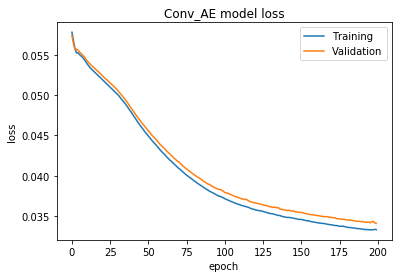

In [32]:
# Con_AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('Conv_AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [33]:
encoded_data = encoder.predict(x_text_con)

In [42]:
# create encoded data

encoded_data = encoded_data.reshape(-1, 3*4)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/dim064_ConAE_encoded.csv',index= False)

# Issue

In [43]:
encoded_som.shape

(410, 12)

In [44]:
x_test.shape

(410, 64)

In [45]:
encoded_som_nonzero.shape

(410, 8)